In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import numpy as np

In [3]:
# read data from csv
target_col = 'income'
df_ = pd.read_csv("adult.csv", index_col=False, na_values=['?'])

# remove missing values
df = df_.dropna().copy()
print(f"Rows dropped {100 * (1 - len(df)/len(df_)):.1f}%")

# merge infrequent countries
countries = df['native-country'].value_counts()
countries = list(countries[countries < 100].index)
df['native-country'].replace(to_replace=countries, value='other', inplace=True)

# one-hot encode categorical features
cat_cols = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country', 'income']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
target_col = next(filter(lambda name: target_col in name, df.columns))
protected_group = next(filter(lambda name: 'gender' in name, df.columns))
print(f"target column name {target_col}")
print(f"protected group column name {protected_group}")
assert protected_group == 'gender_Male' and target_col == 'income_>50K'

# scale numerical features
num_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Rows dropped 7.4%
target column name income_>50K
protected group column name gender_Male


In [5]:
X = df.drop([target_col], axis=1)
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.20, random_state=42
)
print(f"Train size: X {X_train.shape}, y {y_train.shape}")
print(f"Test size: X {X_test.shape}, y {y_test.shape}")

drop_gender = lambda df__: df__.drop([protected_group], axis=1)
X_train_no_gender, X_test_no_gender = drop_gender(X_train), drop_gender(X_test)

def rebalance():
  ft = X_train[protected_group].to_numpy()
  mask_m = (ft == 1).astype(bool)
  mask_f = (ft == 0).astype(bool)
  p = (mask_m / (2 * mask_m.sum())) + (mask_f / (2 * mask_f.sum()))
  ind = np.random.choice(len(ft), len(ft), True, p=p)
  return X_train.iloc[ind], y_train.iloc[ind]
X_train_rebalanced, y_train_rebalanced = rebalance()

Train size: X (28488, 65), y (28488,)
Test size: X (7123, 65), y (7123,)


In [6]:
preds = {
  "logistic": LogisticRegression(max_iter=300).fit(X_train, y_train).predict(X_test),
  "logistic_rebalanced": LogisticRegression(max_iter=300).fit(X_train_rebalanced, y_train_rebalanced).predict(X_test),
  "tree": DecisionTreeClassifier().fit(X_train, y_train).predict(X_test),
  "xgb": xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="logloss").fit(X_train, y_train).predict(X_test),
  # "mlp": MLPClassifier(random_state=1, max_iter=200).fit(X_train, y_train),
  "xgb_no_gender": xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="logloss").fit(X_train_no_gender, y_train).predict(X_test_no_gender),
  "xgb_rebalanced": xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="logloss").fit(X_train_rebalanced, y_train_rebalanced).predict(X_test),
}

In [7]:
gt = y_test.to_numpy()
ft = X_test[protected_group].to_numpy()

mask_m = (ft == 1).astype(bool)
mask_f = (ft == 0).astype(bool)
gt_m, gt_f = gt[mask_m], gt[mask_f]

print(f"num women {mask_f.sum()}, num men {mask_m.sum()}")

def calculate_metrics(out):
  out_m, out_f = out[mask_m], out[mask_f]
  # print(f"tp {np.logical_and(gt == 1, out == 1).sum()}, fp {np.logical_and(gt == 0, out == 1).sum()}, tn {np.logical_and(gt == 0, out == 0).sum()}, fn {np.logical_and(gt == 1, out == 0).sum()}")
  res = {}

  # Statistical parity
  p_m = (out_m == 1).sum() / mask_m.sum()
  p_f = (out_f == 1).sum() / mask_f.sum()
  res["statistical_parity"] = p_m / p_f

  # Equal opportunity
  def tpr(gt, out):
    tp = np.logical_and(gt == 1, out == 1).sum()
    fn = np.logical_and(gt == 1, out == 0).sum()
    return tp / (tp + fn)
  tpr_m = tpr(gt_m, out_m)
  tpr_f = tpr(gt_f, out_f)
  res["equal_opportunity"] = tpr_m / tpr_f

  # Predictive rate parity
  def ppv(gt, out):
    tp = np.logical_and(gt == 1, out == 1).sum()
    fp = np.logical_and(gt == 0, out == 1).sum()
    return tp / (tp + fp)
  ppv_m = ppv(gt_m, out_m)
  ppv_f = ppv(gt_f, out_f)
  res["predictive_parity"] = ppv_m / ppv_f

  res["accuracy"] = (gt == out).mean()
  return res

# calculate_metrics(preds['xgb_no_gender'])

num women 2312, num men 4811


In [8]:
results = {
  name: calculate_metrics(pred)
  for name, pred in preds.items()
}
results

{'logistic': {'statistical_parity': 3.5719215589031474,
  'equal_opportunity': 1.328129065833984,
  'predictive_parity': 0.9908958075755873,
  'accuracy': 0.8509055173382002},
 'logistic_rebalanced': {'statistical_parity': 3.64547222280302,
  'equal_opportunity': 1.3466419883659437,
  'predictive_parity': 0.9844371194202607,
  'accuracy': 0.8485188824933315},
 'tree': {'statistical_parity': 2.7415279099787466,
  'equal_opportunity': 1.186238429798149,
  'predictive_parity': 1.153105226566694,
  'accuracy': 0.8151059946651692},
 'xgb': {'statistical_parity': 3.218254266596497,
  'equal_opportunity': 1.158213224777203,
  'predictive_parity': 0.959086523340672,
  'accuracy': 0.8648041555524357},
 'xgb_no_gender': {'statistical_parity': 3.129965034318169,
  'equal_opportunity': 1.1180327868852458,
  'predictive_parity': 0.9519292604501607,
  'accuracy': 0.8692966446721887},
 'xgb_rebalanced': {'statistical_parity': 3.1106546676182356,
  'equal_opportunity': 1.1562198649951783,
  'predictiv

In [10]:
pd.DataFrame(results)

,logistic,logistic_rebalanced,tree,xgb,xgb_no_gender,xgb_rebalanced
statistical_parity,3.571922,3.645472,2.741528,3.218254,3.129965,3.110655
equal_opportunity,1.328129,1.346642,1.186238,1.158213,1.118033,1.156220
predictive_parity,0.990896,0.984437,1.153105,0.959087,0.951929,0.990554
accuracy,0.850906,0.848519,0.815106,0.864804,0.869297,0.862839


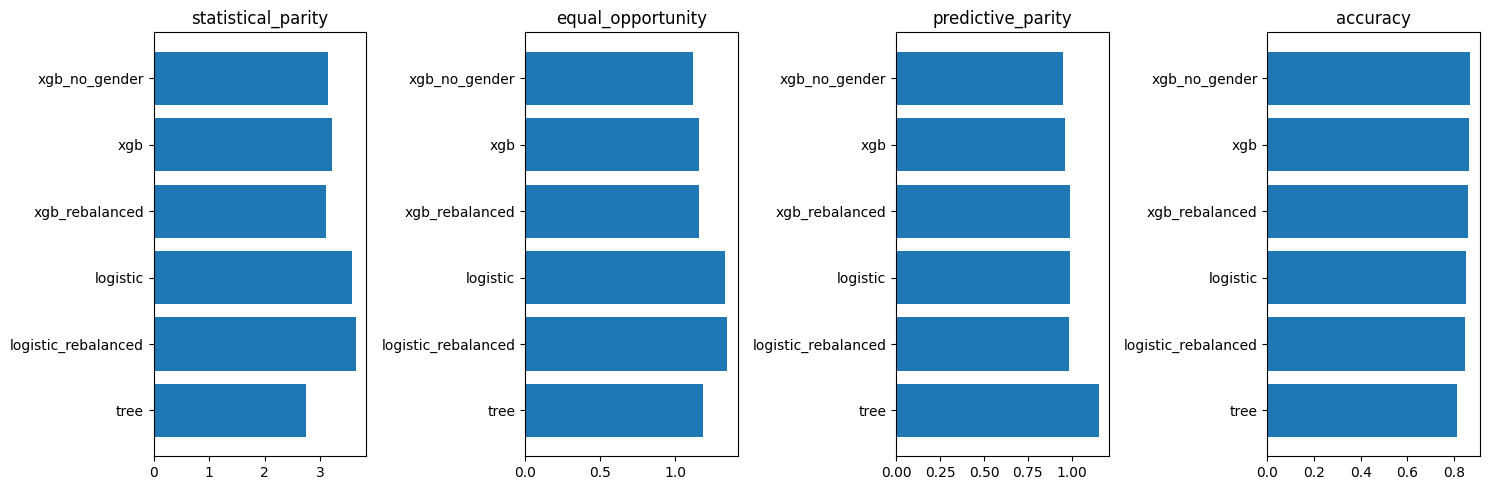

In [11]:
import matplotlib.pyplot as plt

metrics = ['statistical_parity', 'equal_opportunity', 'predictive_parity', 'accuracy']
models = sorted(list(results.keys()), key=(lambda x: results[x]['accuracy']))

fig, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    axs[i].barh(models, values)
    axs[i].set_title(metric)

plt.tight_layout()
plt.show()

